In [255]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [256]:
import os

root = "/content/drive/MyDrive/ds_saswata_sarkar"
csv_dir = f"{root}/csv_files"
out_dir = f"{root}/outputs"

os.makedirs(csv_dir, exist_ok=True)
os.makedirs(out_dir, exist_ok=True)

print("Folders created:")
print(csv_dir)
print(out_dir)


Folders created:
/content/drive/MyDrive/ds_saswata_sarkar/csv_files
/content/drive/MyDrive/ds_saswata_sarkar/outputs


# **Import Libraries**

In [257]:
import os

root = "/content/drive/MyDrive/ds_saswata_sarkar"
out_dir = f"{root}/outputs"

os.makedirs(out_dir, exist_ok=True)

print("Output directory:", out_dir)


Output directory: /content/drive/MyDrive/ds_saswata_sarkar/outputs


In [258]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    f1_score, roc_auc_score, precision_score, recall_score,
    accuracy_score, confusion_matrix, classification_report, roc_curve
)

import joblib


# **Load Dataset**

In [259]:

SENTIMENT_CSV = "/content/drive/MyDrive/fear_greed_index.csv"
TRADER_CSV    = "/content/drive/MyDrive/historical_data (1).csv"

sent = pd.read_csv(SENTIMENT_CSV)
trades = pd.read_csv(TRADER_CSV)



In [260]:
sent.head()


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [261]:
trades.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


# **Preprocess, Clean & Merge**

In [262]:
sent['date'] = pd.to_datetime(sent['date']).dt.date

trades['time_parsed'] = pd.to_datetime(trades['Timestamp IST'], errors='coerce')
trades['Date'] = trades['time_parsed'].dt.date

merged = trades.merge(
    sent[['date', 'classification', 'value']].drop_duplicates(subset=['date']),
    left_on='Date', right_on='date', how='left'
)

# Fill missing sentiment forward
merged['classification'] = merged['classification'].fillna(method='ffill').fillna('Fear')
merged['SentimentScore'] = merged['value'].fillna(method='ffill').fillna(0)

merged.head()

/tmp/ipython-input-3427145411.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged['classification'] = merged['classification'].fillna(method='ffill').fillna('Fear')
/tmp/ipython-input-3427145411.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged['SentimentScore'] = merged['value'].fillna(method='ffill').fillna(0)


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,...,Crossed,Fee,Trade ID,Timestamp,time_parsed,Date,date,classification,value,SentimentScore
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,...,True,0.345404,8.950000e+14,1.730000e+12,2024-02-12 22:50:00,2024-02-12,2024-02-12,Greed,70.0,70.0
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,...,True,0.005600,4.430000e+14,1.730000e+12,2024-02-12 22:50:00,2024-02-12,2024-02-12,Greed,70.0,70.0
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,...,True,0.050431,6.600000e+14,1.730000e+12,2024-02-12 22:50:00,2024-02-12,2024-02-12,Greed,70.0,70.0
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,...,True,0.050043,1.080000e+15,1.730000e+12,2024-02-12 22:50:00,2024-02-12,2024-02-12,Greed,70.0,70.0
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,...,True,0.003055,1.050000e+15,1.730000e+12,2024-02-12 22:50:00,2024-02-12,2024-02-12,Greed,70.0,70.0


# **Basic Cleaning & Target Creation**

*   Remove rows missing essential columns + create Win/Loss target.



In [263]:
merged = merged.dropna(subset=['Closed PnL', 'Size Tokens', 'Execution Price'])

merged['Closed PnL'] = pd.to_numeric(merged['Closed PnL'], errors='coerce').fillna(0)
merged['Win'] = (merged['Closed PnL'] > 0).astype(int)

merged.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,...,Fee,Trade ID,Timestamp,time_parsed,Date,date,classification,value,SentimentScore,Win
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,...,0.345404,8.950000e+14,1.730000e+12,2024-02-12 22:50:00,2024-02-12,2024-02-12,Greed,70.0,70.0,0
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,...,0.005600,4.430000e+14,1.730000e+12,2024-02-12 22:50:00,2024-02-12,2024-02-12,Greed,70.0,70.0,0
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,...,0.050431,6.600000e+14,1.730000e+12,2024-02-12 22:50:00,2024-02-12,2024-02-12,Greed,70.0,70.0,0
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,...,0.050043,1.080000e+15,1.730000e+12,2024-02-12 22:50:00,2024-02-12,2024-02-12,Greed,70.0,70.0,0
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,...,0.003055,1.050000e+15,1.730000e+12,2024-02-12 22:50:00,2024-02-12,2024-02-12,Greed,70.0,70.0,0


# **Feature Engineering**

In [264]:
# Convert numeric
merged['Execution Price'] = pd.to_numeric(merged['Execution Price'], errors='coerce').fillna(0)
merged['Size Tokens'] = pd.to_numeric(merged['Size Tokens'], errors='coerce').fillna(0)

# Trade Value
merged['TradeValue'] = merged['Execution Price'] * merged['Size Tokens']

# Profit efficiency
merged['ProfitPerValue'] = merged.apply(
    lambda r: r['Closed PnL']/r['TradeValue'] if r['TradeValue'] != 0 else 0,
    axis=1
)

# Encode side
merged['IsBuy'] = merged['Side'].str.lower().apply(lambda x: 1 if 'buy' in x else 0)

# Encode sentiment
merged['SentimentEncoded'] = merged['classification'].apply(
    lambda x: 1 if str(x).lower() == 'greed' else 0
)

# Time features
merged['Hour'] = merged['time_parsed'].dt.hour.fillna(0).astype(int)
merged['DayOfWeek'] = merged['time_parsed'].dt.dayofweek.fillna(0).astype(int)

# Final feature list
feature_cols = [
    'TradeValue', 'ProfitPerValue', 'IsBuy',
    'SentimentEncoded', 'SentimentScore',
    'Hour', 'DayOfWeek'
]

merged[feature_cols + ['Win']].head()

,TradeValue,ProfitPerValue,IsBuy,SentimentEncoded,SentimentScore,Hour,DayOfWeek,Win
0,7872.163303,0.0,1,1,70.0,22,0,0
1,127.680000,0.0,1,1,70.0,22,0,0
2,1150.630695,0.0,1,1,70.0,22,0,0
3,1142.038452,0.0,1,1,70.0,22,0,0
4,69.747462,0.0,1,1,70.0,22,0,0


# **Prepare Data for ML**

In [265]:
df_model = merged.dropna(subset=feature_cols + ['Win'])

X = df_model[feature_cols]
y = df_model['Win'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

X_train.shape, X_test.shape


((147856, 7), (63368, 7))

# **Train Random Forest & XGBoost**

In [266]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
xgb = XGBClassifier(
    n_estimators=200, eval_metric='logloss',
    random_state=42, use_label_encoder=False
)

rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [20:26:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

# **Evaluate Both Models**

In [267]:
def evaluate(model):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    return {
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'accuracy': accuracy_score(y_test, y_pred),
        'cm': confusion_matrix(y_test, y_pred),
    }




In [268]:
rf_metrics = evaluate(rf)


rf_metrics

{'f1': 1.0,
 'roc_auc': np.float64(1.0),
 'precision': 1.0,
 'recall': 1.0,
 'accuracy': 1.0,
 'cm': array([[37307,     0],
        [    0, 26061]])}

In [269]:
xgb_metrics = evaluate(xgb)
xgb_metrics

{'f1': 0.999501036309204,
 'roc_auc': np.float64(0.9998139032532471),
 'precision': 0.9997696471762583,
 'recall': 0.9992325697402249,
 'accuracy': 0.9995896982704204,
 'cm': array([[37301,     6],
        [   20, 26041]])}

# **Compare Models & Select Best**

In [270]:
def pick_best(rf_m, xgb_m):
    if rf_m['f1'] > xgb_m['f1']:
        return "RandomForest"
    elif xgb_m['f1'] > rf_m['f1']:
        return "XGBoost"
    else:
        # tie → check ROC
        return "XGBoost" if xgb_m['roc_auc'] > rf_m['roc_auc'] else "RandomForest"

best_model_name = pick_best(rf_metrics, xgb_metrics)
best_model_name


'RandomForest'

# **Feature Importance Plot**

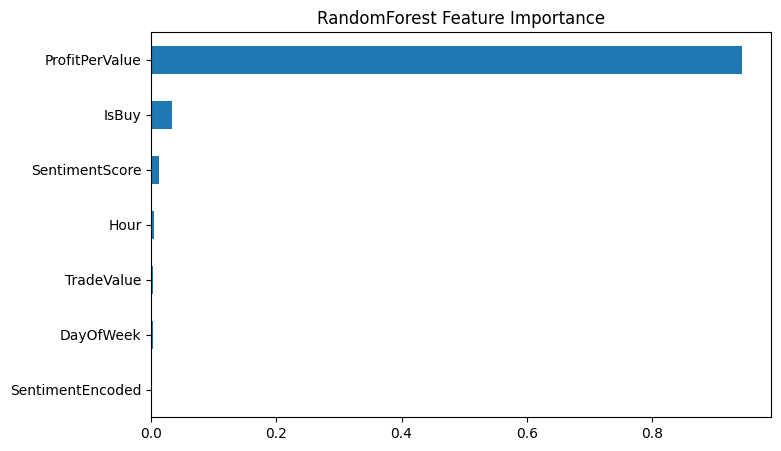

In [271]:
best_model = rf if best_model_name == "RandomForest" else xgb

importances = best_model.feature_importances_
fi = pd.Series(importances, index=feature_cols).sort_values()

plt.figure(figsize=(8,5))
fi.plot(kind='barh')
plt.title(f"{best_model_name} Feature Importance")
plt.savefig(f"{out_dir}/RandomForest Feature Engineering.png", dpi=300, bbox_inches='tight')

plt.show()


# **ROC Curve Comparison**

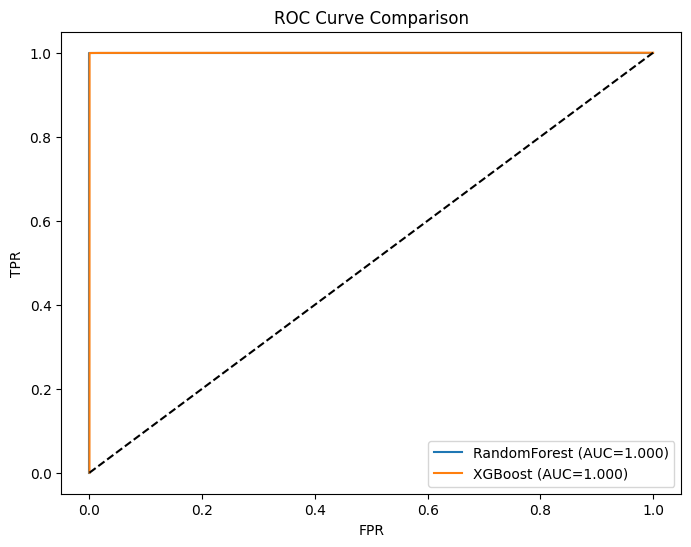

In [272]:
plt.figure(figsize=(8,6))

for name, model in [('RandomForest', rf), ('XGBoost', xgb)]:
    y_proba = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve Comparison")
plt.legend()
plt.savefig(f"{out_dir}/ROC Curve.png", dpi=300, bbox_inches='tight')

plt.show()


# **Sentiment-wise Behavior Analysis(Fear vs Greed)**

# Average Leverage in Fear vs Greed

In [273]:
merged.groupby('classification')['SentimentScore'].mean()

,SentimentScore
classification,
Extreme Fear,15.231051
Extreme Greed,81.770651
Fear,27.705691
Greed,67.610305
Neutral,52.074366


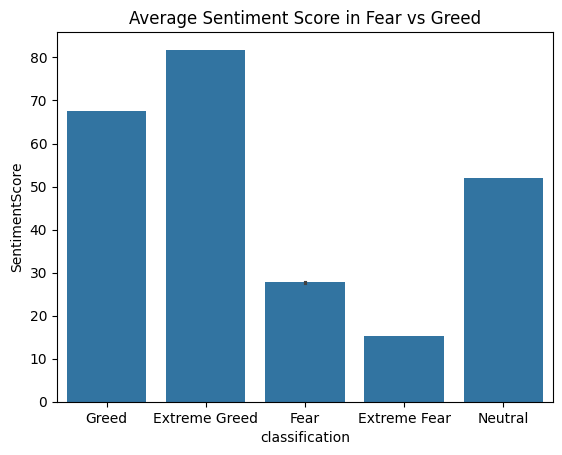

In [274]:
sns.barplot(data=merged, x='classification', y='SentimentScore')
plt.title("Average Sentiment Score in Fear vs Greed")
plt.savefig(f"{out_dir}/Average Sentiment Score in Fear vs Greed.png", dpi=300, bbox_inches='tight')

plt.show()

#Average Profit (closedPnL) in Fear vs Greed

In [275]:
merged.groupby('classification')['Closed PnL'].mean()

,Closed PnL
classification,
Extreme Fear,35.493854
Extreme Greed,95.377129
Fear,46.030630
Greed,39.997999
Neutral,18.894528


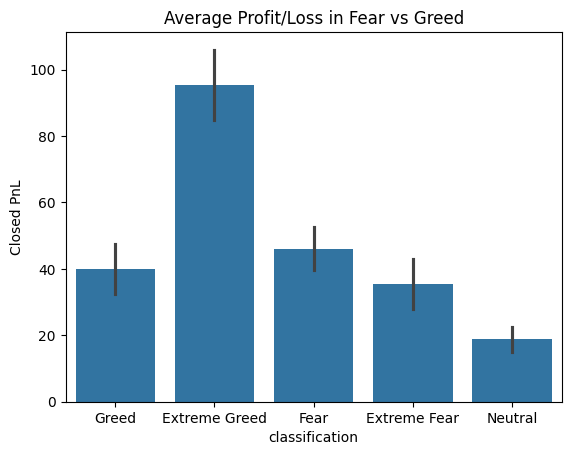

In [276]:
sns.barplot(data=merged, x='classification', y='Closed PnL')
plt.title("Average Profit/Loss in Fear vs Greed")
plt.savefig(f"{out_dir}/Average Profit-Loss in Fear vs Greed.png", dpi=300, bbox_inches='tight')

plt.show()

# Win Rate in Fear vs Greed

In [277]:
merged.groupby('classification')['Win'].mean() * 100


,Win
classification,
Extreme Fear,38.328195
Extreme Greed,46.891468
Fear,39.212982
Greed,42.078116
Neutral,40.295926


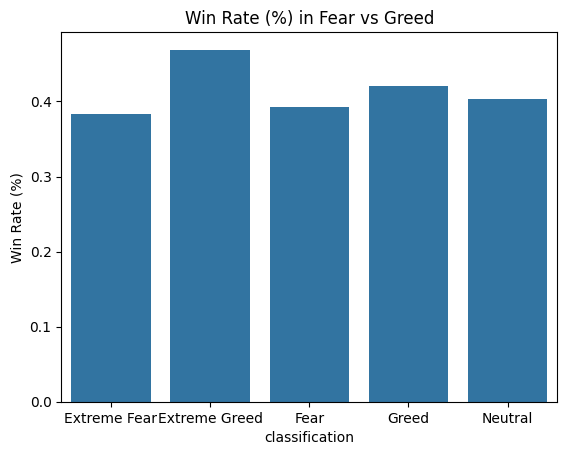

In [278]:
win_rate = merged.groupby('classification')['Win'].mean().reset_index()
sns.barplot(data=win_rate, x='classification', y='Win')
plt.title("Win Rate (%) in Fear vs Greed")
plt.ylabel("Win Rate (%)")
plt.savefig(f"{out_dir}/Win Rate (%) in Fear vs Greed.png", dpi=300, bbox_inches='tight')

plt.show()


#Average Trade Volume (size × price)

In [279]:
merged.groupby('classification')['TradeValue'].mean()


,TradeValue
classification,
Extreme Fear,24741.967479
Extreme Greed,3492.234865
Fear,4258.407682
Greed,3652.804323
Neutral,4139.678460


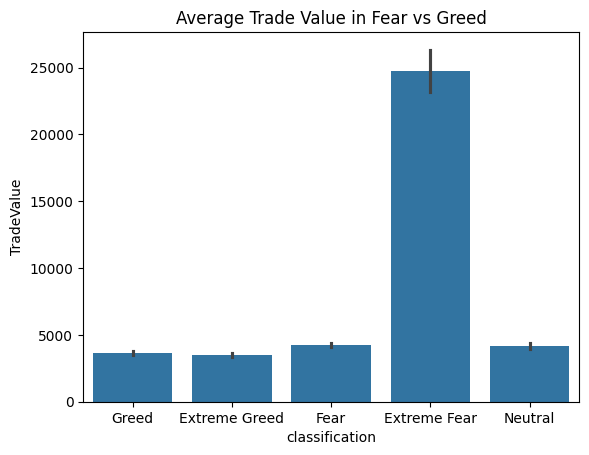

In [280]:
sns.barplot(data=merged, x='classification', y='TradeValue')
plt.title("Average Trade Value in Fear vs Greed")
plt.savefig(f"{out_dir}/Average Trade Value in Fear vs Greed.png", dpi=300, bbox_inches='tight')

plt.show()


# **Distribution Analysis**

#Boxplot: Leverage Distribution

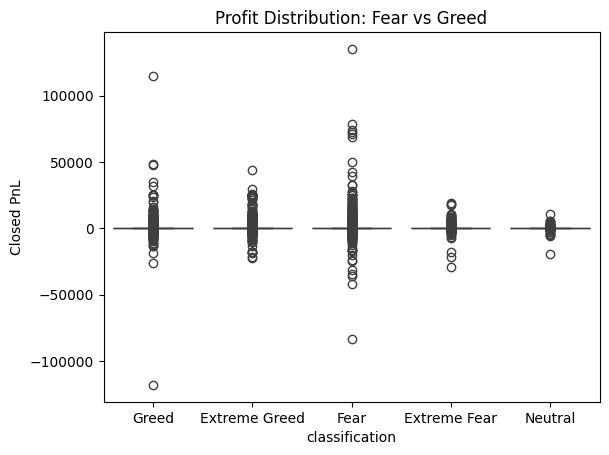

In [281]:
sns.boxplot(data=merged, x='classification', y='Closed PnL')
plt.title("Profit Distribution: Fear vs Greed")
plt.savefig(f"{out_dir}/Profit Distribution: Fear vs Greed BOX.png", dpi=300, bbox_inches='tight')

plt.show()


# **Correlation Heatmap**

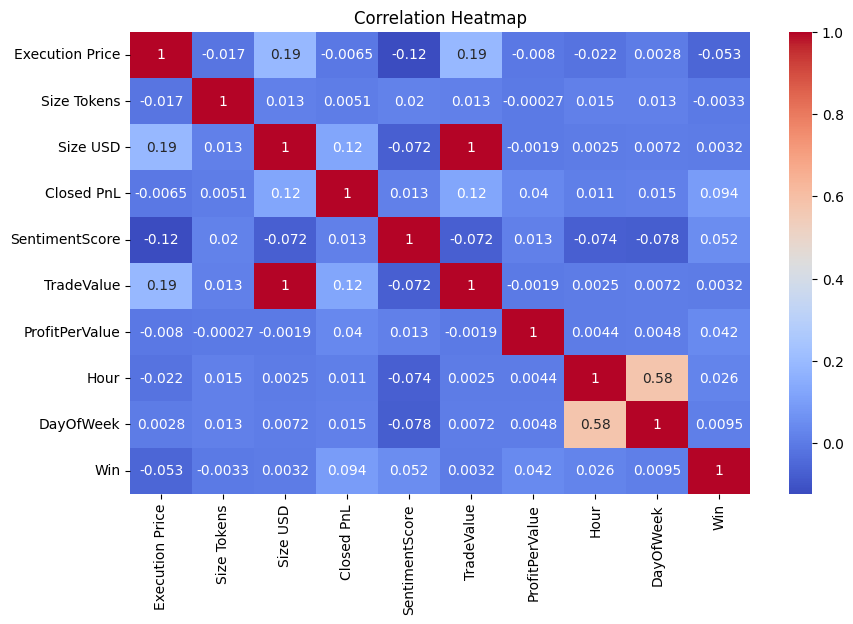

In [282]:
numeric_cols = [
    'Execution Price', 'Size Tokens', 'Size USD', 'Closed PnL',
    'SentimentScore', 'TradeValue', 'ProfitPerValue',
    'Hour', 'DayOfWeek', 'Win'
]

plt.figure(figsize=(10,6))
sns.heatmap(
    merged[numeric_cols].corr(),
    annot=True, cmap='coolwarm'
)
plt.title("Correlation Heatmap")
plt.savefig(f"{out_dir}/Correlation Heatmap.png", dpi=300, bbox_inches='tight')

plt.show()


# **Chi-Square (Sentiment vs Win/Loss)**


In [283]:
from scipy.stats import chi2_contingency

# Build contingency table
ct = pd.crosstab(merged['classification'], merged['Win'])

chi2, p, dof, exp = chi2_contingency(ct)

print("Chi-square Test Result:")
print("Chi2:", chi2)
print("p-value:", p)

if p < 0.05:
    print("👉 Sentiment and Win/Loss are significantly related.")
else:
    print("👉 No significant relationship found.")


Chi-square Test Result:
Chi2: 642.1125500022396
p-value: 1.1884013925878735e-137
👉 Sentiment and Win/Loss are significantly related.


# **t-Test (Fear vs Greed Comparisons)**





#  Profit difference between Fear vs Greed

In [284]:
from scipy.stats import ttest_ind

fear_val = merged[merged['classification']=='fear']['TradeValue']
greed_val = merged[merged['classification']=='greed']['TradeValue']

t, p = ttest_ind(fear_val, greed_val, equal_var=False)
print("Trade Value t-test → p-value:", p)


Trade Value t-test → p-value: nan


/usr/local/lib/python3.12/dist-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


# Trade Value difference between Fear vs Greed

In [285]:
fear_p = merged[merged['classification']=='fear']['Closed PnL']
greed_p = merged[merged['classification']=='greed']['Closed PnL']

t, p = ttest_ind(fear_p, greed_p, equal_var=False)
print("Profit t-test → p-value:", p)


Profit t-test → p-value: nan


# **Win Rate by Hour**

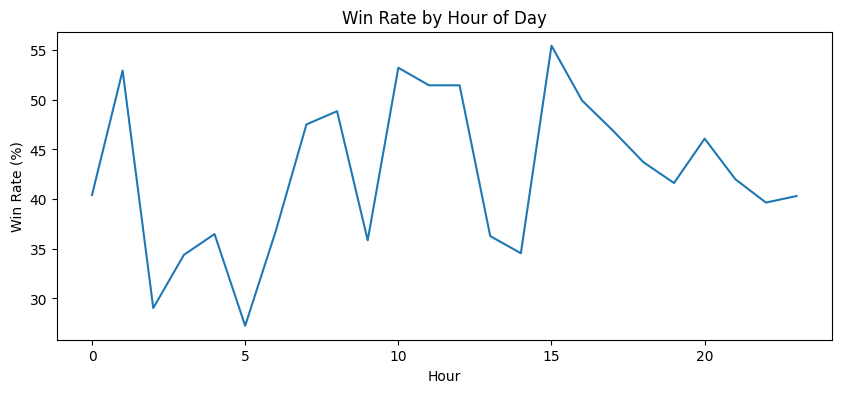

In [286]:
hourly = merged.groupby('Hour')['Win'].mean()*100
hourly.plot(kind='line', figsize=(10,4))
plt.title("Win Rate by Hour of Day")
plt.ylabel("Win Rate (%)")
plt.savefig(f"{out_dir}/Win Rate by Hour of Day.png", dpi=300, bbox_inches='tight')

plt.show()


# **Behaviour Summary Table**

In [287]:
summary = pd.DataFrame({
    "Avg_TradeValue": merged.groupby('classification')['TradeValue'].mean(),
    "Avg_SizeUSD": merged.groupby('classification')['Size USD'].mean(),
    "WinRate": merged.groupby('classification')['Win'].mean()*100,
    "Avg_Profit": merged.groupby('classification')['Closed PnL'].mean()
})

summary


,Avg_TradeValue,Avg_SizeUSD,WinRate,Avg_Profit
classification,,,,
Extreme Fear,24741.967479,24741.967459,38.328195,35.493854
Extreme Greed,3492.234865,3492.234847,46.891468,95.377129
Fear,4258.407682,4258.407696,39.212982,46.030630
Greed,3652.804323,3652.804313,42.078116,39.997999
Neutral,4139.678460,4139.678526,40.295926,18.894528


# Save CSV files

In [288]:
merged.to_csv(f"{csv_dir}/processed_merged.csv", index=False)
print("Processed merged CSV saved at:", f"{csv_dir}/processed_merged.csv")


Processed merged CSV saved at: /content/drive/MyDrive/ds_saswata_sarkar/csv_files/processed_merged.csv


In [289]:
metrics_summary = {
    'RandomForest': {k: v for k, v in rf_metrics.items() if k != 'cm'},
    'XGBoost': {k: v for k, v in xgb_metrics.items() if k != 'cm'}
}

metrics_df = pd.DataFrame.from_dict(metrics_summary, orient='index')

metrics_df.to_csv(f"{csv_dir}/model_metrics_summary.csv", index=True)
print("Model metrics CSV saved at:", f"{csv_dir}/model_metrics_summary.csv")

Model metrics CSV saved at: /content/drive/MyDrive/ds_saswata_sarkar/csv_files/model_metrics_summary.csv


In [290]:
metrics_df.to_csv(f"{csv_dir}/model_metrics_summary.csv", index=False)
print("Model metrics CSV saved at:", f"{csv_dir}/model_metrics_summary.csv")


Model metrics CSV saved at: /content/drive/MyDrive/ds_saswata_sarkar/csv_files/model_metrics_summary.csv
